# Defining and Training RidgeModel

In [1]:
#import libraries
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
#retrieve data
df=pd.read_csv('/kaggle/input/nsei-prev-data/in_nsei_daily.csv',index_col='minute', parse_dates=True)
df.index = df.index.to_pydatetime()
df=pd.DataFrame(df)
df.head

<bound method NDFrame.head of                           ticker    instrument_token      open      high  \
2017-01-02 09:15:00+05:30   NSEI  uf-n-1647516806122   8211.70   8211.70   
2017-01-03 09:15:00+05:30   NSEI  uf-n-1647516806122   8195.25   8219.00   
2017-01-04 09:15:00+05:30   NSEI  uf-n-1647516806122   8201.60   8218.45   
2017-01-05 09:15:00+05:30   NSEI  uf-n-1647516806122   8227.75   8282.55   
2017-01-06 09:15:00+05:30   NSEI  uf-n-1647516806122   8283.50   8306.50   
...                          ...                 ...       ...       ...   
2022-12-26 09:15:00+05:30   NSEI  uf-n-1647516806122  17832.90  18084.10   
2022-12-27 09:15:00+05:30   NSEI  uf-n-1647516806122  18081.90  18149.25   
2022-12-28 09:15:00+05:30   NSEI  uf-n-1647516806122  18093.00  18173.10   
2022-12-29 09:15:00+05:30   NSEI  uf-n-1647516806122  18059.80  18229.70   
2022-12-30 09:15:00+05:30   NSEI  uf-n-1647516806122  18264.70  18265.25   

                                low     close  
2017-01-0

In [3]:
#define the feature columns and target column
features = ['open', 'high', 'low']
target = 'close'

In [4]:
#train/test split
x=df[features]
y=df[target]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

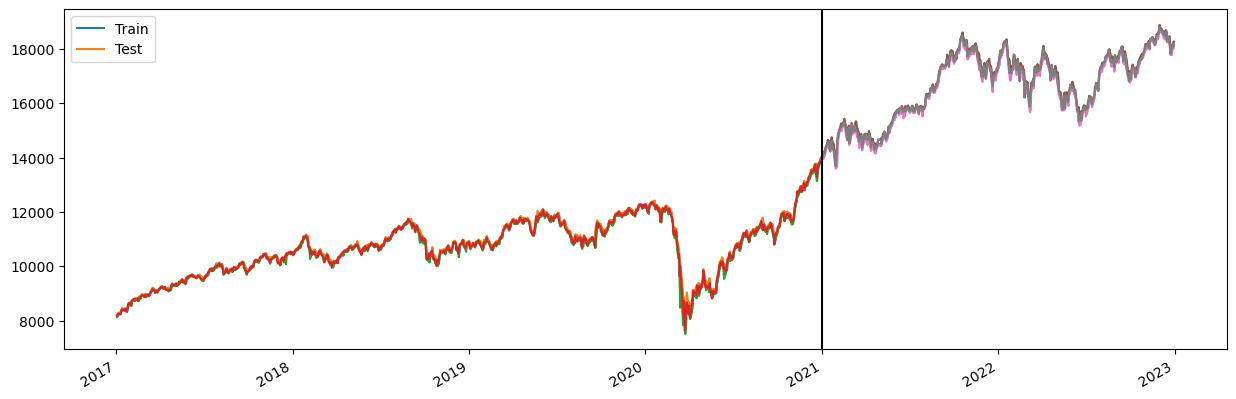

In [5]:
#train/test data plotting
train=df.loc[df.index<'01-01-2021']
test=df.loc[df.index>='31-12-2020']

fig,ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Training Set')
test.plot(ax=ax,label='Test Set')
ax.axvline('01-01-2021',color='black')
ax.legend(['Train','Test'])
plt.show()

In [6]:
# create a Ridge regression model
model = Ridge(alpha=0.5)

In [7]:
#fit the model on the training data
model.fit(x_train, y_train)

Ridge(alpha=0.5)

In [8]:
#make predictions on the testing data
y_pred = model.predict(x_test)

In [9]:
#evaluate model's performance on train data
predict = model.predict(x_train)
r2 = r2_score(y_train, predict)
mse = mean_squared_error(y_train, predict)
rmse = mean_squared_error(y_train, predict, squared=False)
mae = mean_absolute_error(y_train, predict)
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

R2 Score: 0.9997613834529815
Mean Squared Error: 2146.55544942642
Root Mean Squared Error: 46.330934044398674
Mean Absolute Error: 30.541842159641163


In [10]:
#evaluate model's performance on test data
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print("R2 Score:", r2)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

R2 Score: 0.9998192041204527
Mean Squared Error: 1649.7817701818935
Root Mean Squared Error: 40.61750571098493
Mean Absolute Error: 29.260794004076594


# Predict close price on test OHL(open, high, low)

In [11]:
#predictions for data
test_ohl=test[features]
y_pred = model.predict(test_ohl)

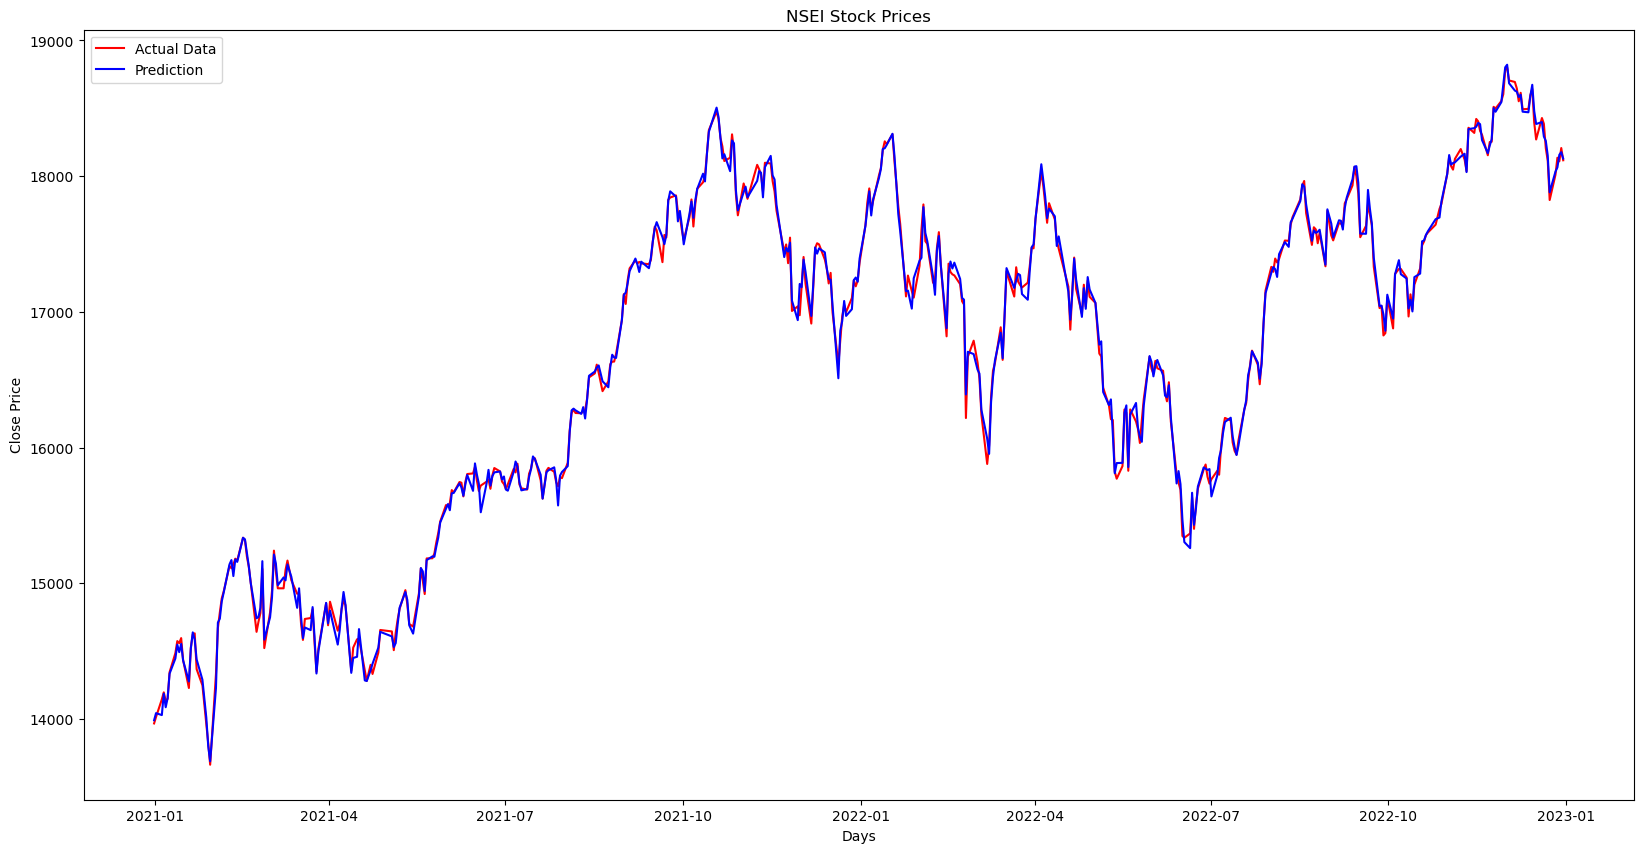

In [12]:
#plotting
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(test.index,test[target], color = 'red', label="Actual Data")
plt.plot(test.index,y_pred, color='blue', label="Prediction")

plt.title('NSEI Stock Prices')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [13]:
#getting dataframe
import pytz
data_=[]
index_ = test.index.tolist()

try:
    for i in range(1,len(index_)):          
        if y_pred[i-1]<test[index_[i-1].strftime('%Y-%m-%d')].close[0]:
            direction='SELL'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': test[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': test[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': y_pred[i-1], 'Pnl':test[index_[i-1].strftime('%Y-%m-%d')].close[0]-test[index_[i].strftime('%Y-%m-%d')].close[0]})
        else:
            direction='BUY'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': test[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': test[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': y_pred[i-1], 'Pnl':test[index_[i].strftime('%Y-%m-%d')].close[0]-test[index_[i-1].strftime('%Y-%m-%d')].close[0]})

    
except KeyboardInterrupt or ValueError:
    print("Output is Stored in csv file: NSEI_STOCK.CSV!")

In [14]:
#storing in csv file
import csv
import os

headers = ['Date', 'Day', 'Current Close Price', 'Next Day Price','Predicted Direction', 'Predicted Value','Pnl']

if os.path.exists('/kaggle/working/nsei_stock.csv'):
    with open('nsei_stock.csv', mode='a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        for row in data_:
            writer.writerow(row)
else:
    with open('nsei_stock.csv', mode='w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        writer.writeheader()
        for row in data_:
            writer.writerow(row)


# Get Next Day Price

In [15]:
#install yfinance library that helps in stock data retrieval 
!pip install yfinance
import yfinance as yf
from time import time
import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.8 MB/s eta 0:00:00


In [16]:
#to import NSEI stock data, set ticker symbol to ^NSEI
tickerSymbol = '^NSEI'
data = yf.Ticker(tickerSymbol)

In [17]:
#retrieve data from this day one year before to today
end_date = datetime.date.today() - datetime.timedelta(days=1)
start_date = end_date - datetime.timedelta(days=365)
day = datetime.date.today()
stock = data.history(start=start_date, end=end_date)

In [18]:
#last day open, high and low price
stock.iloc[-1][['Open','High','Low']]

Open    16977.300781
High    17126.150391
Low     16940.599609
Name: 2023-03-29 00:00:00+05:30, dtype: float64

In [21]:
def next_day_price(stock, day):
    x=stock[['Open','High','Low']]
    y=stock['Close']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    model = Ridge(alpha=0.5)
    model.fit(x_train, y_train)
    predicted_price=model.predict([stock.iloc[-1][['Open','High','Low']]])
    print(f"Predicted price for the {day}:", predicted_price)

In [22]:
#predict price
next_day_price(stock,day)

Predicted price for the 2023-03-31: [17079.50135937]
